<div style="text-align: center;">
    <a href="https://www.dataia.eu/">
        <img border="0" src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="90%"></a>
</div>

# RAMP on variable star type prediction

<i> Balázs Kégl (LAL/CNRS), Marc Moniez (LAL/CNRS), Alex Gramfort (Inria), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction

### Variable stars

Most stars emit light steadily in time, but a small fraction of them has a variable <i>light curve</i>: light emission versus time. We call them <a href = "http://en.wikipedia.org/wiki/Variable_star">variable stars</a>. The light curves are usually <a href="http://en.wikipedia.org/wiki/Periodic_function">periodic</a> and highly regular. There are essentially two reasons why light emission can vary. First, the star itself can be <a href="https://www.youtube.com/watch?v=sXJBrRmHPj8">oscillating</a>, so its light emission varies in time. Second, the star that seems a single point at Earth (because of our large distance) is actually a <a href="http://en.wikipedia.org/wiki/Binary_system"><i>binary system</i></a>: two stars that <a href="https://www.youtube.com/watch?v=1kFFwHkxBiI">orbit around their common center of gravity</a>. When the <a href="http://en.wikipedia.org/wiki/Orbital_plane_%28astronomy%29">orbital plane</a> is parallel to our line of view, the stars <a href="http://csep10.phys.utk.edu/astr162/lect/binaries/eclipsing.html">eclipse each other</a> periodically, creating a light curve with a <a href="http://www.dlr.de/en/desktopdefault.aspx/tabid-5170/8702_read-20474/">charateristic signature</a>. Identifying, classifying, and analyzing variable stars are hugely important for calibrating distances, and making these analyses automatic will be crucial in the upcoming sky survey projects such as <a href="http://www.lsst.org/lsst/">LSST</a>.

### The EROS1 database, a catalog of light curves 

Our data is coming from the <a href="http://eros.in2p3.fr/">EROS1 project</a> that took data between 1990 and 1994.
400 <a href="http://www.atnf.csiro.au/outreach/education/senior/astrophysics/photometry_photographicastro.html">photographic plates</a> were taken of the <a href="http://en.wikipedia.org/wiki/Large_Magellanic_Cloud">Large Magellanic Cloud</a> with the <a href="http://www.eso.org/public/teles-instr/lasilla/1mschmidt/">ESO-Schmidt 1m telescope</a>. Each plate covers the same $5^\circ \times 5^\circ$ field, centered at $\alpha  = 5h18m43s$, $\delta = −69d42m17s$ in the <a href="http://en.wikipedia.org/wiki/Celestial_coordinate_system">celestial coordinate system</a>. Photos were taken in two <a href = "http://science-edu.larc.nasa.gov/EDDOCS/Wavelengths_for_Colors.html">frequency bands</a> (red: 630nm; blue: 385nm), digitized at the <a href="http://en.wikipedia.org/wiki/Paris_Observatory">Observatoire de Paris</a>, and analyzed at the <a href="http://cc.in2p3.fr/">IN2P3 Computing Center</a>.

### Selecting variable stars

The full catalog contains 8 million objects. We estimated the probability of a star being stable using an in-house algorithm and selected the $\simeq 1\%$ least stable stars. The light curve of each selected star was then visually inspected, and the star was either declared stable or assigned a variability type and a quality index. The variability types are <a href="http://en.wikipedia.org/wiki/Binary_star#Eclipsing_binaries">eclipsing binary</a>, <a href="http://en.wikipedia.org/wiki/Cepheid_variable">Cepheid</a>, <a href="http://en.wikipedia.org/wiki/RR_Lyrae_variable">RR-Lyrae</a>, <a href="http://en.wikipedia.org/wiki/Mira_variable">Mira</a>, and other (the variability is clearly established, but the type is unclear). The quality index was visually estimated from 1 (lowest signal to background ratio) to 3 (best signal to background ratio). A total of 22802 variable objects were found that include 9046 RR-Lyrae, 2758 Cepheids, 1596 eclipsing binaries, 890 Miras, and 8512 unclassified objects. About 10% of the data was lost in the data archeology step that included converting the measurements from a native <a href="http://en.wikipedia.org/wiki/Physics_Analysis_Workstation">PAW</a> format to csv, giving us a total of 19429 stars.

### Selecting data

For the RAMP, we decided to drop all instances in the "unclassified object" category since the interpretation of this type was unclear. We then randomly selected 30% of the data for training, giving us 3641 training instances.

The data consists of two files, <a href="https://drive.google.com/file/d/0BzwKr6zuOkdRRWt5bnYyc2JNS0U/view?usp=sharing">train.csv</a> contains "static" features in a classical row-wise csv table, and <a href="https://drive.google.com/file/d/0BzwKr6zuOkdRMXVuRE9FSXNjZTQ/view?usp=sharing">train_varlength_features.csv.gz</a> is a table that contains all the time series. The contents is obtained with `get_train_data` function below.

# Exploratory data analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
pd.set_option('display.max_columns', None)

## Get access to the training data

In [2]:
import problem

X_df, y = problem.get_train_data()

## The static features

<span style="color:red">Red variables</span> are ids, labels, or other human-annotated features, so they should not be used as input in the classification. <span style="color:lightblue">Light blue variables</span> are legal but not likely to contribute information to the classification. Black variables are definitely discriminative.

<ul>
    <li> <code><b><span style="color:red">patch_id</span></b></code>: The catalogue is organized by tiles corresponding to 1 cm<sup>2</sup> patches on the plates, this is their id.
    <li> <code><b><span style="color:red">star_id_b, star_id_r</span></b></code>: The id of the star within the patch. <code>patch_id</code> and <code>star_id_b</code> or <code>star_id_r</code> identify the stars uniquely, and we use <code>[patch_id]_[star_id_b]</code> for indexing the stars in the pandas table.
    <li> <code><b>magnitude_b, magnitude_r</b></code>: The average apparent luminosity of the star (in two frequency bands). <a href="http://www.astro-tom.com/technical_data/magnitude_scale.htm">Magnitude</a> is a logarithmic measure, and the higher it is, the lower the apparent luminosity is.
    <li> <code><b><span style="color:lightblue">asc_d, asc_m, asc_s</span></b></code>: <a href="http://en.wikipedia.org/wiki/Celestial_coordinate_system">Celestial</a> <a href="http://en.wikipedia.org/wiki/Right_ascension">right ascension</a> (coordinate) of the star, measured in degrees, minutes, and seconds, respectively.
    <li> <code><b><span style="color:lightblue">dec_d, dec_m, dec_s</span></b></code>: <a href="http://en.wikipedia.org/wiki/Celestial_coordinate_system">Celestial</a> <a href="http://en.wikipedia.org/wiki/Declination">declination</a> (coordinate) of the star, measured in degrees, minutes, and seconds, respectively.
    <li> <code><b><span style="color:black">period</span></b></code>: the estimated period of the light curve. For the correct period, it should be divided by <code>div_period</code>
    <li> <code><b><span style="color:lightblue">frequency</span></b></code>: $1/$<code>period</code>, so it is redundant.
    <li> <code><b><span style="color:lightblue">num_points_good_b, num_points_good_r</span></b></code>: Number of good light curve measurements (some measurements can be corrupted). 
    <li> <code><b><span style="color:black">asym_b, asym_r</span></b></code>: Unknown semantics.
    <li> <code><b><span style="color:black">log_p_not_variable</span></b></code>: Logarithm of the estimated probability that the star is stable.
    <li> <code><b><span style="color:black">sigma_flux_b, sigma_flux_r</span></b></code>: The square root of the total variance of the light measurements (indicating the amplitude of the variability).
    <li> <code><b><span style="color:red">type</span></b></code>: The label to predict.
    <li> <code><b><span style="color:red ">quality</span></b></code>: Human-annotated measure of the quality of the time curve. The higher the better.
    <li> <code><b><span style="color:black ">div_period</span></b></code>: The algorithm that estimates the <code>period</code> sometimes finds a multiple of the period. These cases were human-detected, and the divisor was recorded. In principle this variable is not available automatically as an observable, but we are confident that it could be obtained automatically, so we allow it as an input.
</ul> 

In [3]:
X_df.head()

,patch_id,star_id_b,star_id_r,magnitude_b,magnitude_r,asc_d,asc_m,asc_s,dec_d,dec_m,dec_s,period,frequency,num_points_good_b,num_points_good_r,asym_b,asym_r,log_p_not_variable,sigma_flux_b,sigma_flux_r,quality,div_period,time_points_b,time_points_r,light_points_b,light_points_r,error_points_b,error_points_r,bkg_points_b,bkg_points_r,polltn_points_b,polltn_points_r
0,135.0,9613.0,10062.0,19.1458,18.8044,5.0,40.0,51.37,-70.0,13.0,58.78,2.35495,0.424637,123.0,124.0,1.277780,0.653333,-2.80984,36.1471,46.4916,1.0,7.0,"[290.3, 291.35, 322.25, 326.24, 345.18, 347.23...","[290.34, 291.31, 322.29, 326.28, 345.23, 347.1...","[19.15, 18.96, 18.86, 19.17, 18.96, 19.03, 19....","[18.75, 18.66, 18.5, 18.68, 18.77, 18.69, 18.7...","[0.13, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13, 0.1...","[0.16, 0.25, 0.14, 0.17, 0.18, 0.23, 0.14, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.13, 0.13, 0.11, 0.11, 0.14, 0.19, 0.08, 0.1..."
1,271.0,4304.0,4708.0,17.6799,15.3077,5.0,28.0,51.55,-69.0,23.0,19.17,280.00000,0.003571,123.0,125.0,0.921875,1.777780,-14.51460,136.1020,1269.7400,2.0,2.0,"[290.3, 291.35, 322.25, 326.24, 345.18, 347.23...","[290.34, 291.31, 322.29, 326.28, 345.23, 347.1...","[17.7, 17.97, 17.83, 17.71, 17.6, 17.4, 17.46,...","[15.43, 15.66, 15.66, 15.5, 15.28, 15.28, 15.3...","[0.12, 0.1, 0.08, 0.09, 0.11, 0.09, 0.11, 0.12...","[0.1, 0.11, 0.09, 0.09, 0.06, 0.07, 0.06, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.02, 0.02, 0.0, 0.0, 0.02, 0.02, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,295.0,8200.0,8739.0,19.3872,18.8606,5.0,27.0,7.89,-68.0,43.0,14.47,1.42264,0.702919,122.0,124.0,2.388890,1.883720,-6.50514,32.1775,48.2365,2.0,3.0,"[290.3, 291.35, 322.25, 326.24, 345.18, 347.23...","[290.34, 291.31, 322.29, 326.28, 345.23, 347.1...","[20.16, 19.37, 19.28, 19.53, 19.53, 19.95, 19....","[19.19, 18.81, 18.86, 19.06, 19.05, 18.89, 18....","[0.25, 0.14, 0.13, 0.16, 0.22, 0.26, 0.19, 0.2...","[0.27, 0.25, 0.17, 0.21, 0.24, 0.25, 0.15, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0,...","[0.01, 0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0....","[0.03, 0.03, 0.02, 0.02, 0.06, 0.11, 0.05, 0.0...","[0.06, 0.03, 0.03, 0.03, 0.05, 0.06, 0.02, 0.0..."
3,223.0,530.0,557.0,16.4751,15.5033,5.0,35.0,41.69,-70.0,56.0,13.25,193.54800,0.005167,124.0,124.0,0.252525,1.431370,-6.12045,368.7470,1026.6800,0.0,3.0,"[290.3, 291.35, 322.25, 326.24, 345.18, 347.23...","[290.34, 291.31, 322.29, 326.28, 345.23, 347.1...","[16.73, 16.3, 16.25, 16.38, 16.22, 16.07, 16.0...","[15.24, 15.55, 15.74, 15.69, 15.55, 15.37, 15....","[0.14, 0.12, 0.11, 0.18, 0.23, 0.16, 0.2, 0.16...","[0.25, 0.21, 0.13, 0.13, 0.12, 0.13, 0.12, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,354.0,10866.0,12022.0,17.8301,16.7286,5.0,21.0,50.48,-69.0,17.0,32.07,1.81622,0.550594,123.0,116.0,1.510200,0.633803,-2.07771,121.7490,318.9770,1.0,5.0,"[290.3, 291.35, 322.25, 326.24, 345.18, 347.23...","[290.34, 291.31, 322.29, 326.28, 345.23, 347.1...","[17.67, 17.51, 17.78, 17.73, 17.6, 17.87, 18.0...","[16.97, 16.88, 16.72, 16.67, 16.47, 17.12, 16....","[0.13, 0.1, 0.1, 0.1, 0.12, 0.1, 0.12, 0.14, 0...","[0.13, 0.14, 0.1, 0.1, 0.08, 0.18, 0.08, 0.08,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0.02, 0.0, 0....","[0.19, 0.22, 0.13, 0.11, 0.11, 0.35, 0.05, 0.0..."


## The labels

In [4]:
label_names = {1: 'binary', 2: 'cepheid', 3: 'rr_lyrae', 4: 'mira'}
labels = list(label_names.keys())
y_series = pd.Series(y).replace(label_names)
y_series.head()

0    rr_lyrae
1        mira
2    rr_lyrae
3      binary
4    rr_lyrae
dtype: object

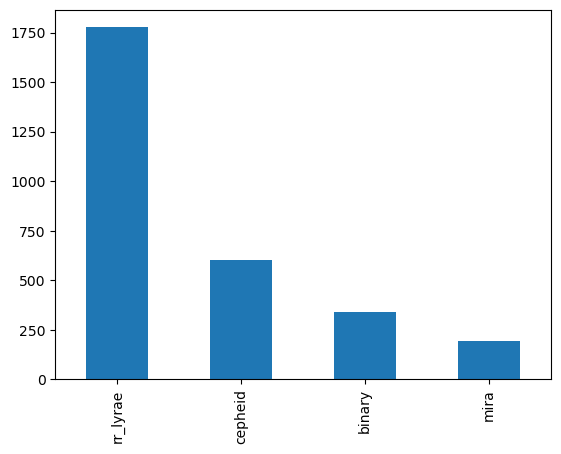

In [5]:
_ = y_series.value_counts().plot(kind="bar")

## Some classwise histograms and scatterplots

In [6]:
colors = ['r', 'b', 'g', 'm']
def plot_classwise_normalized(feature, bins=None):
    if bins is None:
        bins = np.linspace(X_df[feature].min(), X_df[feature].max(), 15)
    for label, color in zip(labels, colors):
        plt.hist(X_df[y == label][feature].values, density=True, bins=bins, 
                 alpha=0.5, color=color)

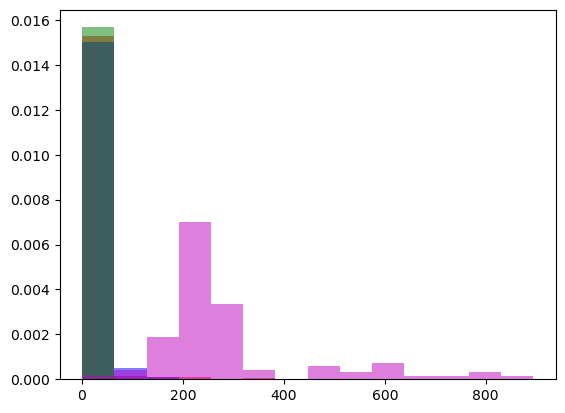

In [7]:
plot_classwise_normalized('period')

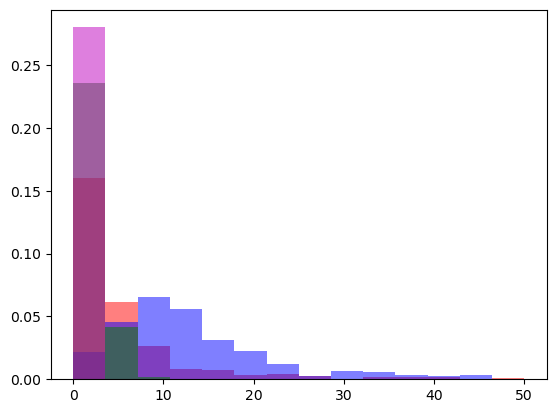

In [8]:
plot_classwise_normalized('period', bins=np.linspace(0, 50, 15))

Observe the aliasing below.

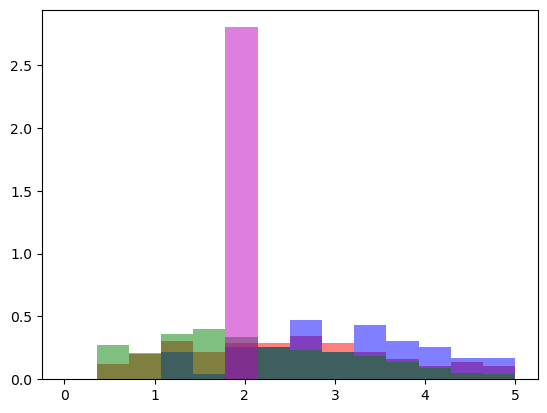

In [9]:
plot_classwise_normalized('period', bins=np.linspace(0, 5, 15))

In [10]:
X_df['real_period'] = X_df['period'] / X_df['div_period']

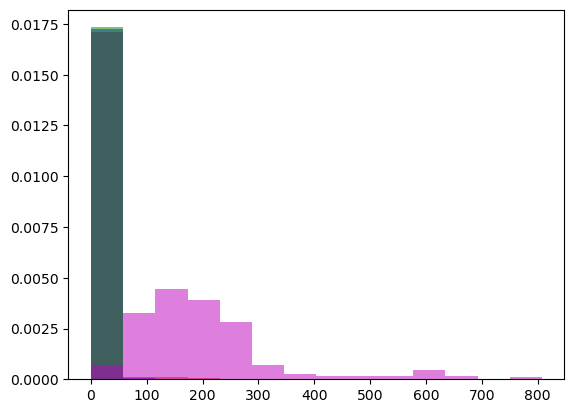

In [11]:
plot_classwise_normalized('real_period')

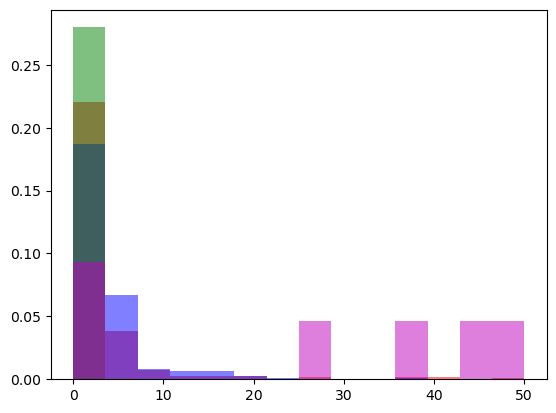

In [12]:
plot_classwise_normalized('real_period', bins=np.linspace(0, 50, 15))

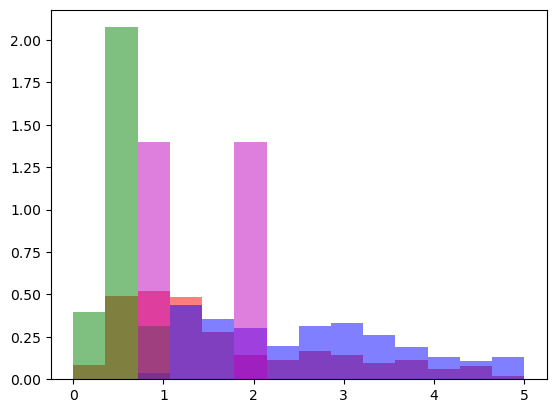

In [13]:
plot_classwise_normalized('real_period', bins=np.linspace(0, 5, 15))

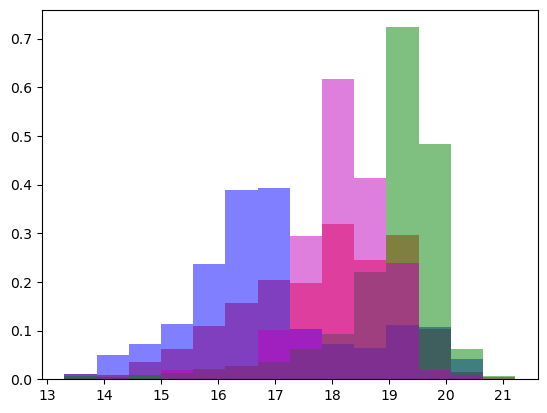

In [14]:
plot_classwise_normalized('magnitude_b')

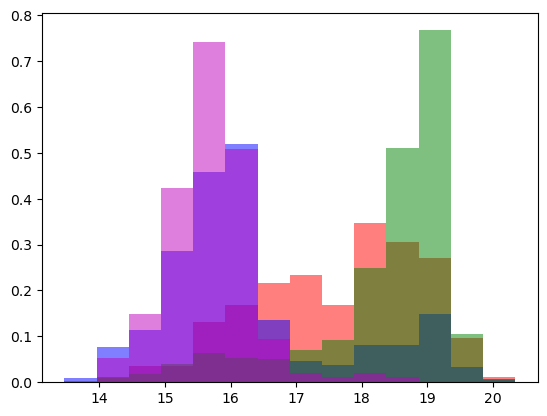

In [15]:
plot_classwise_normalized('magnitude_r')

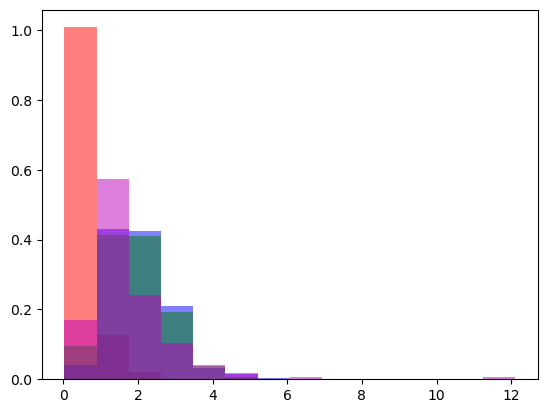

In [16]:
plot_classwise_normalized('asym_b')

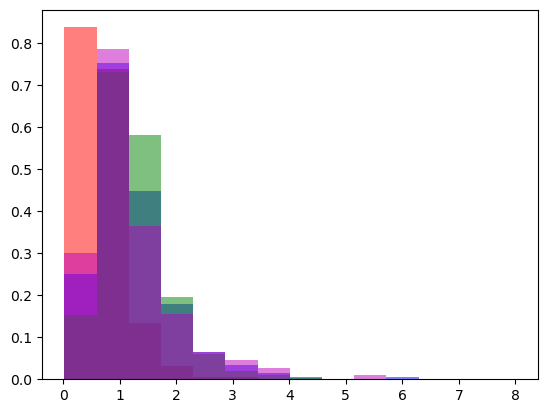

In [17]:
plot_classwise_normalized('asym_r')

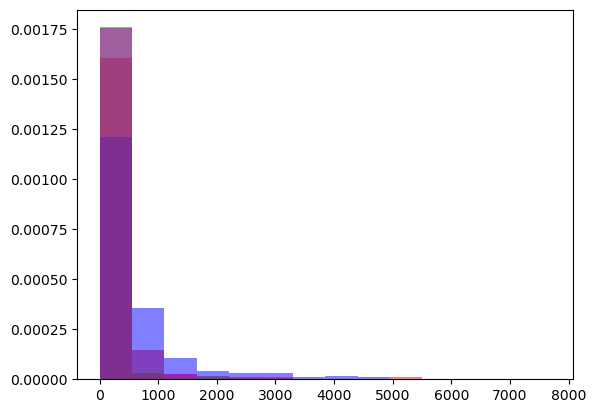

In [18]:
plot_classwise_normalized('sigma_flux_b')

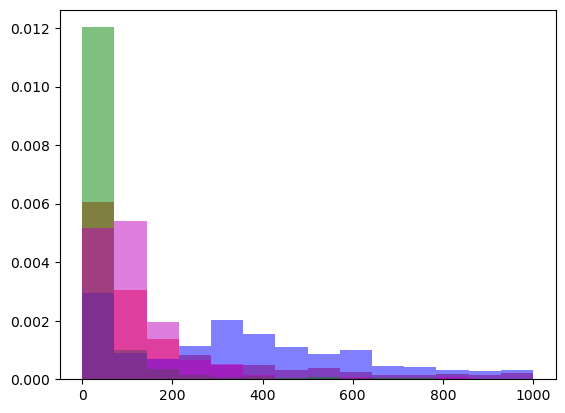

In [19]:
plot_classwise_normalized('sigma_flux_b', bins=np.linspace(0, 1000, 15))

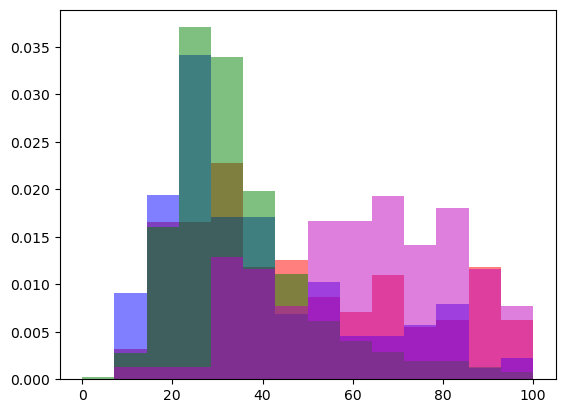

In [20]:
plot_classwise_normalized('sigma_flux_b', bins=np.linspace(0, 100, 15))

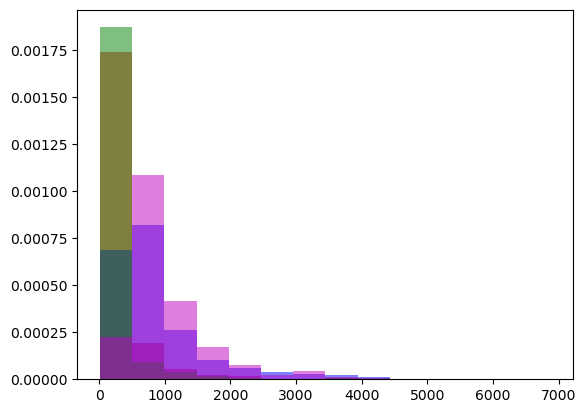

In [21]:
plot_classwise_normalized('sigma_flux_r')

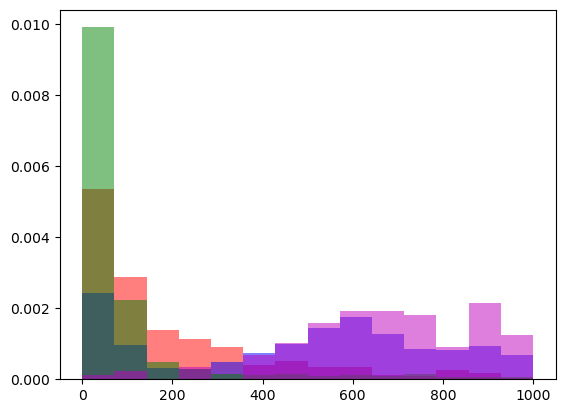

In [22]:
plot_classwise_normalized('sigma_flux_r', bins=np.linspace(0, 1000, 15))

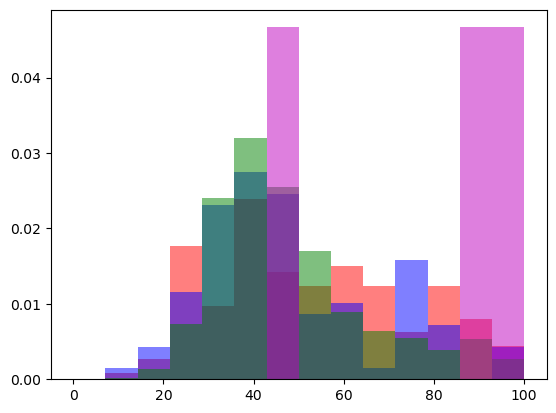

In [23]:
plot_classwise_normalized('sigma_flux_r', bins=np.linspace(0, 100, 15))

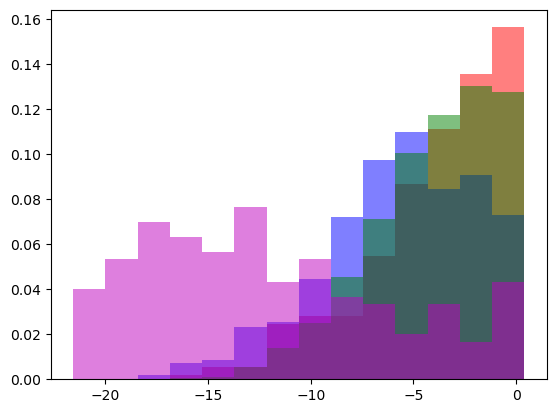

In [24]:
plot_classwise_normalized('log_p_not_variable')

In [25]:
colors = ['r', 'b', 'g', 'm']
def plot_classwise_scatter(feature1, feature2, range1=None, range2=None):
    if range1 is None:
        range1 = [X_df[feature1].min(), X_df[feature1].max()]
    if range2 is None:
        range2 = [X_df[feature2].min(), X_df[feature2].max()]
    for label, color in zip(labels, colors):
        plt.xlim(range1[0], range1[1])
        plt.ylim(range2[0], range2[1])
        plt.scatter(X_df[y == label][feature1], 
                    X_df[y == label][feature2],
            alpha=0.3, s=80, c=color, marker='.');

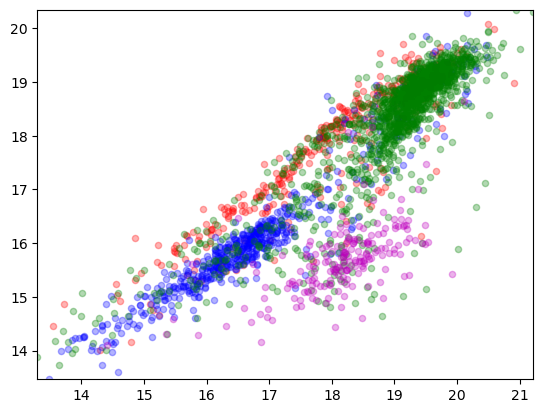

In [26]:
plot_classwise_scatter('magnitude_b', 'magnitude_r')

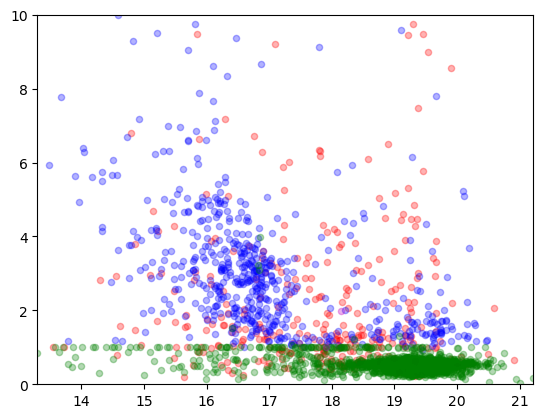

In [27]:
plot_classwise_scatter('magnitude_b', 'real_period', range1=None, range2=[0,10])

## The time series

Each column contains a list of floating point numbers.

<ul>
    <li> <code><b><span style="color:black">time_points_b, time_points_r</span></b></code>: The time (in unit of days) when the photos were taken. Note that the filters had to be changed so the time points of the blue and red frequency band are slighty different.
    <li> <code><b><span style="color:black">light_points_b, light_points_r</span></b></code>: The light points measured at the time points.
    <li> <code><b><span style="color:black">error_points_b, error_points_r</span></b></code>: Uncertainties (error bars) on the light measurements.
    <li> <code><b><span style="color:lightblue">bkg_points_, bkg_points_r</span></b></code>: Background noise measured at the time points.
    <li> <code><b><span style="color:lightblue">polltn_points_b, polltn_points_r</span></b></code>: Pollution noise measured at the time points.
</ul> 

33.0
124.0
11.0
125.0


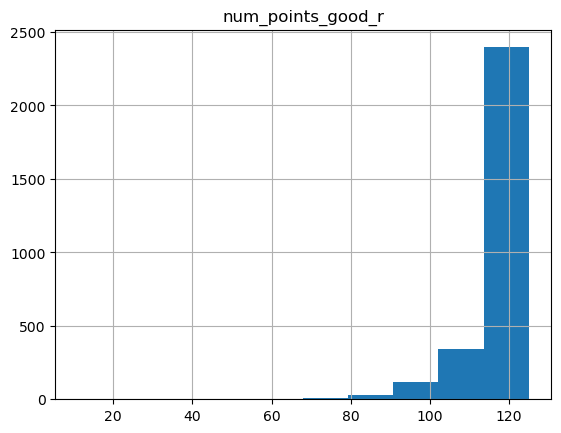

In [28]:
X_df.hist('num_points_good_r')
print(min(X_df['num_points_good_b']))
print(max(X_df['num_points_good_b']))
print(min(X_df['num_points_good_r']))
print(max(X_df['num_points_good_r']))

### Plotting time curves

Set the patch id and star id below.

In [29]:
patch_id = 98
star_id_b = 477

def star_key(slab_id, star_id_b):
    return str(slab_id) + '_' + str(star_id_b)

In [30]:
X_df = X_df.set_index(X_df.apply(lambda row: "%d_%d" % (row['patch_id'], row['star_id_b']), axis=1))

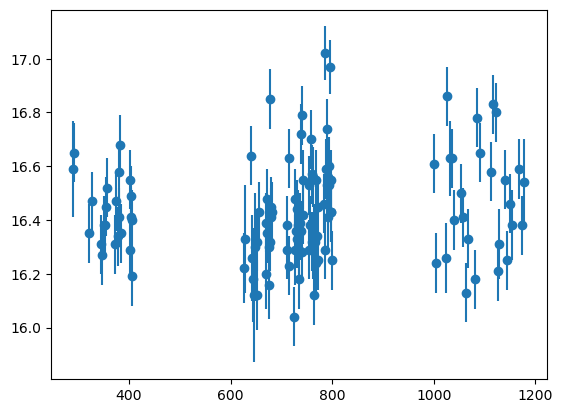

In [31]:
time_points = X_df.loc[star_key(patch_id, star_id_b)]['time_points_b']
light_points = X_df.loc[star_key(patch_id, star_id_b)]['light_points_b']
error_points = X_df.loc[star_key(patch_id, star_id_b)]['error_points_b']
plt.errorbar(time_points, light_points, yerr=error_points, fmt='o');

The raw measurements seem rather messy. The scatter of the plots is visibly larger than the measurement uncertainty (which makes it, by definition, a variable star), but there is no visible periodicity. We can use the estimated period to overplot several periods of the curve ("fold" the time series) using the following function.

In [32]:
def fold_time_series(time_point, period, div_period):
    real_period = period / div_period
    return time_point % real_period  # modulo real_period

In [33]:
period = X_df.loc[star_key(patch_id, star_id_b)]['period']
div_period = X_df.loc[star_key(patch_id, star_id_b)]['div_period']
print(period, div_period)

1.41875 1.0


In [34]:
time_points_folded = [fold_time_series(time_point, period, div_period) 
                      for time_point in time_points]

The resulting curve has a characteristic signature. 

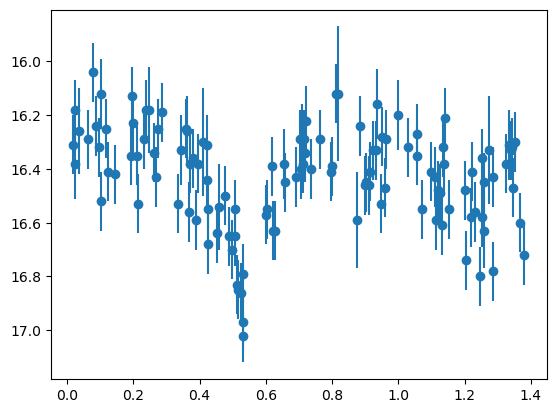

In [35]:
plt.gca().invert_yaxis()
plt.errorbar(time_points_folded, light_points, yerr=error_points, fmt='o');

# Submission

The goal of the RAMP is to classify the stars into one of the four types. In your code you will have access both to the static features and the time series. The submission site will have several examples that you can start from.

## The feature extractor

The input data are stored in a dataframe. To go from a dataframe to a numpy array we will
a scikit-learn column transformer. The first example we will write will just consist in
selecting a subset of columns we want to work with.

In [36]:
cols = [
    'magnitude_b', 
    'magnitude_r',
    'period',
    'asym_b', 
    'asym_r', 
    'log_p_not_variable', 
    'sigma_flux_b', 
    'sigma_flux_r', 
    'quality', 
    'div_period',
]

from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    ('passthrough', cols)
)

X_array = transformer.fit_transform(X_df)

In [37]:
X_array

array([[1.91458e+01, 1.88044e+01, 2.35495e+00, ..., 4.64916e+01,
        1.00000e+00, 7.00000e+00],
       [1.76799e+01, 1.53077e+01, 2.80000e+02, ..., 1.26974e+03,
        2.00000e+00, 2.00000e+00],
       [1.93872e+01, 1.88606e+01, 1.42264e+00, ..., 4.82365e+01,
        2.00000e+00, 3.00000e+00],
       ...,
       [1.59894e+01, 1.48990e+01, 7.37556e-01, ..., 1.68217e+03,
        0.00000e+00, 5.00000e+00],
       [1.80060e+01, 1.84855e+01, 6.94903e+00, ..., 7.63486e+01,
        1.00000e+00, 6.00000e+00],
       [1.79219e+01, 1.79493e+01, 3.31077e+00, ..., 9.65315e+01,
        2.00000e+00, 1.00000e+00]])

Let's look at how to transform line curves.

The following feature extractor takes the light curve, bins it into <code>num_bins</code> bins, and return the bin means. It works with one band at a time.

In [38]:
def fold_time_series(time_point, period, div_period):
    return (time_point -
            (time_point // (period / div_period)) * period / div_period)


def get_bin_means(X_df, num_bins, band):
    feature_array = np.empty((len(X_df), num_bins))

    for k, (_, x) in enumerate(X_df.iterrows()):
        period = x['period']
        div_period = x['div_period']
        real_period = period / div_period
        bins = [i * real_period / num_bins for i in range(num_bins + 1)]

        time_points = np.array(x['time_points_' + band])
        light_points = np.array(x['light_points_' + band])
        time_points_folded = \
            np.array([fold_time_series(time_point, period, div_period)
                      for time_point in time_points])
        time_points_folded_digitized = \
            np.digitize(time_points_folded, bins) - 1

        for i in range(num_bins):
            this_light_points = light_points[time_points_folded_digitized == i]
            if len(this_light_points) > 0:
                feature_array[k, i] = np.mean(this_light_points)
            else:
                feature_array[k, i] = np.nan  # missing

    return feature_array


get_bin_means(X_df.iloc[:2], 5, 'r')

array([[18.69068966, 18.86333333, 19.01230769, 18.92055556, 18.73166667],
       [15.60714286, 15.54458333, 15.23852941, 15.15911765, 15.32315789]])

For this we will use a funtion transformer that will get applied to both red and blues curves.

In [39]:
from sklearn.preprocessing import FunctionTransformer

transformer_r = FunctionTransformer(
    lambda X_df: get_bin_means(X_df, 5, 'r')
)

transformer_b = FunctionTransformer(
    lambda X_df: get_bin_means(X_df, 5, 'b')
)

transformer = make_column_transformer(
    (transformer_r, ['period', 'div_period', 'time_points_r', 'light_points_r']),
    (transformer_b, ['period', 'div_period', 'time_points_b', 'light_points_b']),
)

X_array = transformer.fit_transform(X_df)
X_array.shape

(2912, 10)

Combined with some static features and plugged into a random forest it reads;

In [40]:
import numpy as np

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


def fold_time_series(time_point, period, div_period):
    return (time_point -
            (time_point // (period / div_period)) * period / div_period)


def get_bin_means(X_df, num_bins, band):
    feature_array = np.empty((len(X_df), num_bins))

    for k, (_, x) in enumerate(X_df.iterrows()):
        period = x['period']
        div_period = x['div_period']
        real_period = period / div_period
        bins = [i * real_period / num_bins for i in range(num_bins + 1)]

        time_points = np.array(x['time_points_' + band])
        light_points = np.array(x['light_points_' + band])
        time_points_folded = \
            np.array([fold_time_series(time_point, period, div_period)
                      for time_point in time_points])
        time_points_folded_digitized = \
            np.digitize(time_points_folded, bins) - 1

        for i in range(num_bins):
            this_light_points = light_points[time_points_folded_digitized == i]
            if len(this_light_points) > 0:
                feature_array[k, i] = np.mean(this_light_points)
            else:
                feature_array[k, i] = np.nan  # missing

    return feature_array


transformer_r = FunctionTransformer(
    lambda X_df: get_bin_means(X_df, 5, 'r')
)

transformer_b = FunctionTransformer(
    lambda X_df: get_bin_means(X_df, 5, 'b')
)

cols = [
    'magnitude_b',
    'magnitude_r',
    'period',
    'asym_b',
    'asym_r',
    'log_p_not_variable',
    'sigma_flux_b',
    'sigma_flux_r',
    'quality',
    'div_period',
]

common = ['period', 'div_period']
transformer = make_column_transformer(
    (transformer_r, common + ['time_points_r', 'light_points_r']),
    (transformer_b, common + ['time_points_b', 'light_points_b']),
    ('passthrough', cols)
)

pipe = make_pipeline(
    transformer,
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier(max_depth=5, n_estimators=10)
)


def get_estimator():
    return pipe

## Testing using a scikit-learn pipeline

In [41]:
import problem
from sklearn.model_selection import cross_val_score

X_df, y = problem.get_train_data()

scores = cross_val_score(get_estimator(), X_df, y, cv=2, scoring='accuracy')
print(scores)

[0.87087912 0.90728022]


## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).